In [1]:
from pathlib import Path
import time
import csv

import pylab as pl
from IPython import display
import torch
from torch.distributions import Categorical
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import numpy as np

from riemannianSgd import RiemannianSGD
from model import Model
import helpers

OUT_DIMENSIONS = 2
NEG_SAMPLES = 5
EPOCH = 300
torch.set_default_dtype(torch.float64)

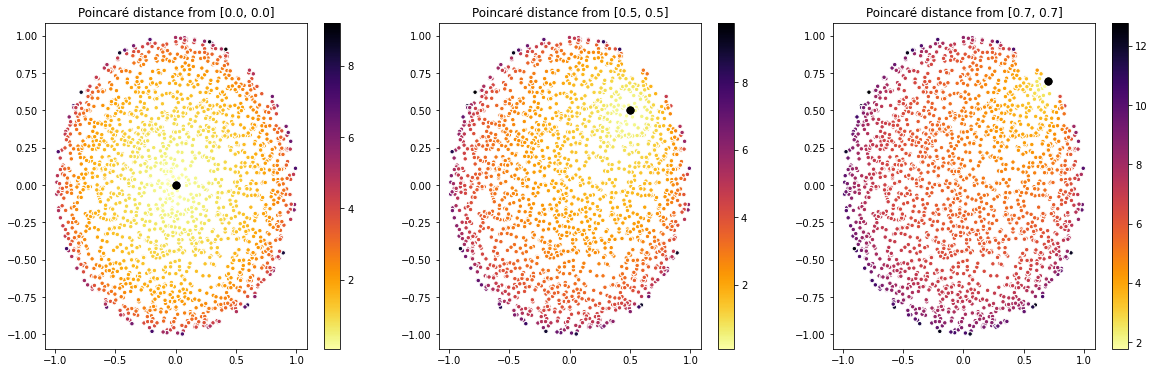

In [2]:
def norm(x, axis=None):
    return np.linalg.norm(x, axis=axis)

def poincare_dist(u, v, eps=1e-5):
    d = 1 + 2 * norm(u-v)**2 / ((1 - norm(u)**2) * (1 - norm(v)**2) + eps)
    return np.arccosh(d)

# plot unit circle in R^2
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(1, 3, 1)

# sample within unit circle in R^2
n = 2000
theta = np.random.uniform(0, 2*np.pi, n)
u = np.random.uniform(0, 1, n)
r = np.sqrt(u)
X = np.array([r * np.cos(theta), r * np.sin(theta)]).T
i = np.random.choice(n)

xi = [0.0, 0.0]
dist_xi = [poincare_dist(xi, x) for x in X]
im = ax.scatter(X[:,0], X[:,1], s=20, c=dist_xi, cmap='inferno_r', edgecolors='white')
ax.scatter(xi, xi, s =50, c='black')
ax.set_title('Poincaré distance from ' + str(xi))
plt.colorbar(im)

ax = fig.add_subplot(1, 3, 2)
xi = [0.5, 0.5]
dist_xi = [poincare_dist(xi, x) for x in X]
im = ax.scatter(X[:,0], X[:,1], s=20, c=dist_xi, cmap='inferno_r', edgecolors='white')
ax.scatter(xi, xi, s =50, c='black')
ax.set_title('Poincaré distance from ' + str(xi))
plt.colorbar(im);

ax = fig.add_subplot(1, 3, 3)
xi = [0.7, 0.7]
dist_xi = [poincare_dist(xi, x) for x in X]
im = ax.scatter(X[:,0], X[:,1], s=20, c=dist_xi, cmap='inferno_r', edgecolors='white')
ax.scatter(xi, xi, s =50, c='black')
ax.set_title('Poincaré distance from ' + str(xi))
plt.colorbar(im)
plt.show();

In [3]:

# m = Categorical(torch.tensor([ 2, 100, 1, 0.5 ]))
# print(m.sample())

# data, objects, weights = helpers.load_edge_list(Path("data", "dist1Sample.csv"))
data, weights, objects, neighbors, diff_summed, num_relations = helpers.load_dataset("data/dist1Sample.csv")

# id2 = ancestor, id1 = descendant according to descendant name in near column
# "ancestor_concept_id","descendant_concept_id","dist"
# "id2","id1","weight","descendant_concept_name"
print(data.shape)
print(objects)
print(len(objects))
print(weights)
ref = pd.read_csv(Path('data','ref.csv'))
#create a dict with data indices as keys
dictData = dict(enumerate(objects))
# replace concept_id with concept_name in dict
# print(objects.index(4274025))

for key, value in dictData.items():
    dictData[key] = ref.loc[ref['concept_id'] == value].concept_name.values[0]

# print(dictData)

Processing dataset...
Dataset size: 1062
Relations: 1034
Vocabulary size: 944
(1062, 2)
[4297708, 441840, 3655421, 437382, 433595, 4042140, 4231813, 4196732, 37311320, 4179304, 45769239, 3655422, 4274025, 4146314, 4275345, 3663207, 40480457, 4089228, 43021226, 4168498, 4213737, 432453, 4167864, 45769238, 3655034, 4314326, 4154764, 4306059, 443364, 4077657, 4178553, 4022231, 4135707, 444118, 44804780, 4024567, 37109856, 4270559, 4052283, 434489, 4275189, 4189521, 4041436, 40482449, 437770, 4293037, 4198564, 4013076, 4022929, 4311690, 44806379, 44792549, 4089226, 4187777, 35626371, 36685453, 44809728, 4030518, 4234245, 4231693, 443571, 4205534, 44788785, 4219415, 4203262, 4267789, 37208363, 442326, 4059373, 3661912, 4029539, 37394473, 4092723, 4021773, 763940, 4269696, 44804786, 4097161, 4042232, 4086556, 320136, 4014014, 40482718, 44790785, 4047640, 4115259, 4150385, 443584, 434910, 4269861, 44792546, 44791206, 4014003, 4145386, 4210043, 4306164, 4061173, 4210125, 4065677, 4115406, 4028

Graph with 944 nodes and 1034 edges


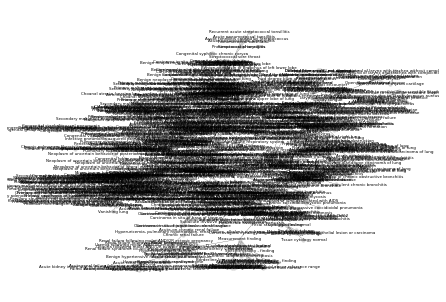

In [4]:
g = nx.Graph()
g.add_edges_from(data)

pos = nx.spring_layout(g)
# pos = nx.kamada_kawai_layout(g)
pos_attrs = {}
for node, coords in pos.items():
    pos_attrs[node] = (coords[0], coords[1] + 0.08)

print(nx.info(g))
plt.figure()
nx.draw(g, pos=pos, node_size=10, node_color="lightgray", width=0.2)
nx.draw_networkx_labels(g, labels=dictData, pos=pos, font_size=4)
plt.savefig(Path("data", "hierarchy.png"), dpi=300)
plt.show()

In [5]:
# cat_dist = Categorical(probs=torch.from_numpy(weights)) # was weights
# cat_dist = Categorical(probs=torch.from_numpy(np.ones(len(objects)))) # was weights
### weight_temp = list(np.ones(len(objects)))
###weight_temp[objects.index(4274025)] = 20 # 4274025 put weight to 20, all other are 1
cat_dist = Categorical(probs=torch.from_numpy(weights)) # was weights

# print(np.ones(len(objects)))
#print(len(np.ones(len(objects))))
unif_dist = Categorical(probs=torch.ones(len(objects),) / len(objects))
# print(torch.ones(len(objects),) / len(objects))

# model = Model(dim=OUT_DIMENSIONS, size=data.shape[0])
model = Model(dim=OUT_DIMENSIONS, size=len(objects))
# print(model.dist(torch.tensor(0.5), torch.tensor(0.4)))
# print(model.dist_2(0.5, 0.4))


optimizer = RiemannianSGD(model.parameters())

loss_func = CrossEntropyLoss()
batch_X = torch.zeros(10, NEG_SAMPLES + 2, dtype=torch.long)
batch_y = torch.zeros(10, dtype=torch.long)

EPOCH = 200
n = 0

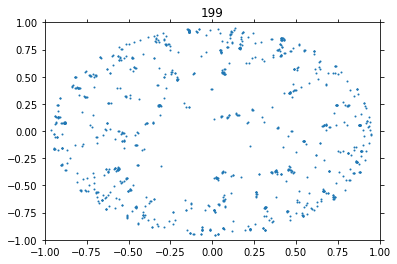

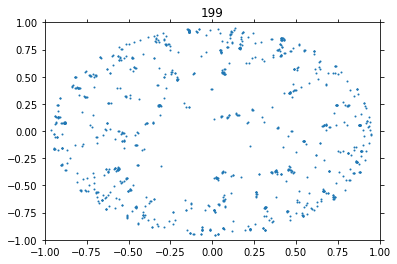

In [6]:
pl.figure()
# pl.xlim(-1, 1)
# pl.ylim(-1, 1)
# pl.axis('off')

while n < EPOCH:
    if n < 20:
        lr = 0.003
        sampler = cat_dist
    else:
        lr = 0.3
        sampler = unif_dist

    perm = torch.randperm(data.shape[0])
    # dataset_rnd = data.loc[perm, ]
    dataset_rnd = torch.as_tensor(data[perm, ])

##############################################
    coordinates = model.embedding.weight.detach().numpy()
    # pl.annotate(dictData[x], (coordinates[x,0], coordinates[x,1]), fontsize=4)
    pl.gca().clear()
    pl.xlim(-1, 1)
    pl.ylim(-1, 1)
    pl.title(n)
    pl.scatter(coordinates[:,0], coordinates[:,1],s=1)
    display.clear_output(wait=True)
    display.display(pl.gcf())
##############################################

    # for i in tqdm(range(0, data.shape[0] - data.shape[0] % 10, 10)):
    for i in range(0, data.shape[0] - data.shape[0] % 10, 10):
        batch_X[:, :2] = dataset_rnd[i: i + 10]

        for j in range(10):
            a = set(sampler.sample([2 * NEG_SAMPLES]).numpy())
            # print("a")
            # print(a)
            # print("BATCHX0")
            # print(data[batch_X[j, 0]])
            # print(set(data[batch_X[j, 0]]))
            # print("BATCHX1")
            # print(data[batch_X[j, 1]])
            # print(set(data[batch_X[j, 1]]))
            # print("positives")
            # print((set(data[batch_X[j, 0]]) | set(data[batch_X[j, 1]])))
            # print("a")
            # print(a)
            negatives = list(a - (set(data[batch_X[j, 0]]) | set(data[batch_X[j, 1]])))
            # print("negatives")
            # print(negatives)
            batch_X[j, 2 : len(negatives)+2] = torch.LongTensor(negatives[:NEG_SAMPLES])

        optimizer.zero_grad()
        preds = model(batch_X)

        loss = loss_func(preds.neg(), batch_y)
        loss.backward()
        optimizer.step(lr=lr)
    n = n+1

n = 0

Parameter containing:
tensor([[ 0.5195,  0.7968],
        [ 0.1661,  0.7665],
        [ 0.1791,  0.9016],
        ...,
        [-0.0800,  0.9367],
        [-0.1379,  0.9131],
        [-0.8996, -0.3076]], requires_grad=True)
[0 1]
0
1
tensor(0.5195, grad_fn=<SelectBackward>)
tensor(0.7968, grad_fn=<SelectBackward>)
tensor(0.1661, grad_fn=<SelectBackward>)
tensor(0.7665, grad_fn=<SelectBackward>)


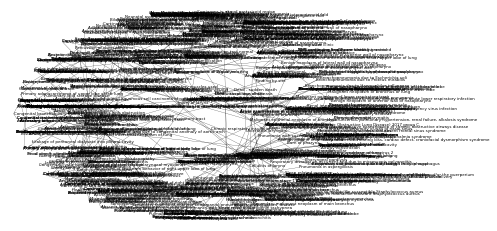

In [7]:
import matplotlib.pyplot as plt

# model = torch.load("poincare_model_dim_2.pt")
# coordinates = model["state_dict"]["embedding.weight"].numpy()
# print(model.state_dict()['embedding.weight'])
coordinates = model.embedding.weight
print(coordinates)
#######################################################
# # some experiment with 3d plotting in TF projector
# x_np = coordinates.detach().numpy()
# x_df = pd.DataFrame(x_np)
# x_df.to_csv(Path('data','tmp.tsv'), sep="\t", index=False, header=False)
#
# df = pd.Series(dictData)
# df.to_string()
# print(df)
# df.to_csv(Path('data','lab.tsv'), sep="\t", index=False, header=False,
#           quoting=csv.QUOTE_NONNUMERIC)
# # df["index"].map(dictData)
###########################

# print(len(objects))
#print(data)

plt.figure()
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axis('off')

# import pandas
# ref = pandas.read_csv('~/Git/hyperbolic-learning/data/wordnet/ref.csv')
data, objects, weights = helpers.load_edge_list(Path("data", "dist1Sample.csv"))
# data, weights, names, neighbors, diff_summed, num_relations = helpers.load_dataset("data/dist1Sample.csv")

for x in range(coordinates.shape[0]):
    plt.annotate(dictData[x], (coordinates[x,0], coordinates[x,1]), fontsize=4)
    # plt.annotate(dictData[x], (coordinates[x,0]*100, coordinates[x,1]*100),
    #              bbox={"fc":"white", "alpha":0.9}, fontsize=4)
i=0
print(data[i])
print(data[i][0])
print(data[i][1])
# print(coordinates)
print(coordinates[data[i][0], 0])
print(coordinates[data[i][0], 1])

print(coordinates[data[i][1], 0])
print(coordinates[data[i][1], 1])
# x_values = [coordinates[]]

# Plot edges of original hierarchy
for i in range(data.shape[0]):
    x_values = [coordinates[data[i][0], 0].detach().numpy(), coordinates[data[i][1], 0].detach().numpy()]
    y_values = [coordinates[data[i][0], 1].detach().numpy(), coordinates[data[i][1], 1].detach().numpy()]
#
#     x_val = [coordinates[data[x][0],0].detach().numpy(), coordinates[data[x][1],1].detach().numpy()]
#     y_val = [coordinates[data[x][0],0].detach().numpy(), coordinates[data[x][1],1].detach().numpy()]
    plt.plot(x_values, y_values, color="black", linewidth=0.2)

plt.savefig(Path("data", "hierarchy_embed.png"), dpi=300, facecolor="white")
plt.show()

# coordinates = model.embedding.weight
# coordinates = coordinates.detach().numpy()
# coordinates
#print(coordinates.shape[0])
# # print(coordinates)
# #pl.plot(pl.randn(100))
#
# for x in range(coordinates.shape[0]):
#     pl.annotate(dictData[x], (coordinates[x,0], coordinates[x,1]), fontsize=4)
#     # pl.scatter(coordinates[x,0], coordinates[x,1])
#     display.clear_output(wait=True)
#     display.display(pl.gcf())
#
#     # pl.annotate(dictData[x], (coordinates[x,0], coordinates[x,1]), fontsize=4)
#